In [2]:
from IPython.display import HTML
import warnings 
warnings.filterwarnings('ignore')

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
%matplotlib inline

## MOCPy introduction
--------------------------

MOCPy is a python library for creating, manipulate and parse MOCs (Multi-Order Coverage maps).
A MOC describes an arbitrary region on the sky. MOCs can be used to:

- Represent the spatial footprint of a catalog (source and/or image survey).
- Compare the footprints, perform fast intersections, unions, differences.
- Filter an astropy table by discarding all the sources that do not lie in the MOC region.

MOCPy's code can be found on GitHub: https://github.com/cds-astro/mocpy
You can install it: `pip install mocpy`

MOCPy's documentation: https://cds-astro.github.io/mocpy/

In [2]:
import mocpy
from mocpy import MOC
mocpy.__version__

'0.7.0'

## Use astroquery.cds to get spatial footprints (MOCs)
----------------------------------------------------------------------

MOCs can be retrieved from ``astroquery.cds``. ``astroquery.cds`` offers a python access API  to the MOCServer that stores ~20000 vizier catalog MOCs and ~500 HiPS image survey MOCs!

astroquery.cds documentation https://astroquery.readthedocs.io/en/latest/cds/cds.html#getting-started

Exercice: let's retrieve the MOC of:

- The MOC representing the footprint of all the HST combined surveys (Clue: see the astroquery.cds documentation, an example is given) at the order 8 (i.e. the precision of the MOC)
- The MOC reprensenting the footprint of SDSS9: ID='CDS/P/SDSS9/color'

In [3]:
from regions import CircleSkyRegion
from astropy.coordinates import Angle, SkyCoord
from astroquery.cds import cds

### HST MOC footprint
# We want to retrieve all the HST surveys i.e. the HST surveys covering any region of the sky.
allsky = CircleSkyRegion(SkyCoord(0, 0, unit="deg"), Angle(180, unit="deg"))
hst_moc = cds.query_region(region=allsky,
    # We want a mocpy object instead of an astropy table
    return_moc=True,
    # The order of the MOC
    max_norder=8,
    # Expression on the ID meta-data
    meta_data="ID=*HST*"
)

### SDSS9
sdss_moc=cds.find_datasets(meta_data="ID=CDS/P/SDSS9/color", return_moc=True)

## Manipulate MOCs using MOCPy
---------------------------------------------

``astroquery.cds`` return mocpy.MOC typed objects. Use MOCPy (see the API of the mocpy.MOC class https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC) to manipulate them, for example you could:

- compute their intersection/union
- serialize them to FITS/json, save them to FITS files
- filter an astropy table to keep only the sources being on a MOC (the intersection between sdss and the hst surveys).

In [4]:
sdss_and_hst_moc = sdss_moc.intersection(hst_moc)
print(sdss_moc.serialize(format='fits'))
sdss_moc.write("sdss_moc.fits", format="fits", overwrite=True)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f78d1357940>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f78b6f7bb38>]


## Plot a MOC using matplotlib
----------------------------------------

Let's see how to plot a MOC using matplotlib.
here is an example on the MOCPy's documentation: https://cds-astro.github.io/mocpy/examples/examples.html#loading-and-plotting-the-moc-of-sdss

Exercice: Use matplotlib and MOCPy to draw the MOCs of HST and SDSS that we downloaded from `astroquery.cds`. Plot these 2 MOCs on the same `matplotlib.axe.Axe`

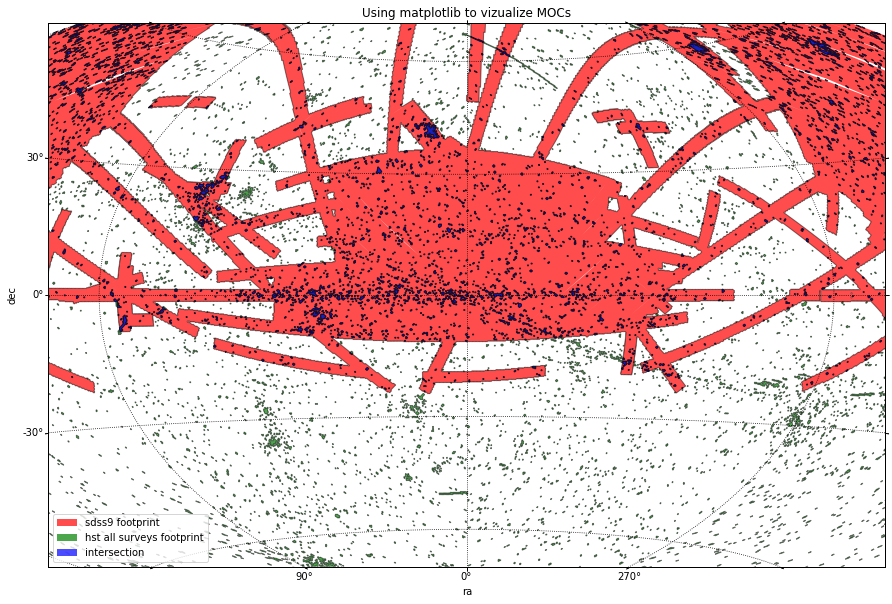

In [5]:
from mocpy import WCS

import astropy.units as u

from matplotlib import path, patches
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))

with WCS(fig, 
         fov=200 * u.deg,
         center=SkyCoord(0, 0, unit='deg', frame='icrs'),
         coordsys='icrs',
         rotation=Angle(0, u.degree),
         projection="AIT") as wcs:
    # Create a matplotlib axe and give it a astropy.wcs.WCS-like object
    ax = fig.add_subplot(1, 1, 1, projection=wcs)

    # Fill the MOC in red with an opacity of 50%
    sdss_moc.fill(ax=ax, wcs=wcs, edgecolor='r', facecolor='r', linewidth=0, fill=True, alpha=0.7, label="sdss9 footprint")
    # Draw its perimeter in black
    sdss_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)
    # Fill the MOC in red with an opacity of 50%
    hst_moc.fill(ax=ax, wcs=wcs, edgecolor='g', facecolor='g', linewidth=0, fill=True, alpha=0.7, label="hst all surveys footprint")
    # Draw its perimeter in black
    hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)
    
    sdss_and_hst_moc.fill(ax=ax, wcs=wcs, edgecolor='b', facecolor='b', linewidth=0, fill=True, alpha=0.7, label="intersection")
    # Draw its perimeter in black
    sdss_and_hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

# Usual matplotlib calls
plt.title("Using matplotlib to vizualize MOCs")
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()
plt.grid(color="black", linestyle="dotted")
plt.show()
plt.close()

Change the WCS parameters:
- The projection: see the astropy documentation for ``astropy.wcs.WCS`` https://docs.astropy.org/en/stable/wcs/
- Zoom, unzoom by changing the fov quantity
- Change the coordinate system from galactic to icrs
- ``fill`` and ``border`` draw on a matplotlib axe. These methods accept additional stylistic kwargs: https://matplotlib.org/api/_as_gen/matplotlib.patches.PathPatch.html#matplotlib.patches.PathPatch

## Filter an astropy.Table by a MOC
---------------------------------------------
 
1. Retrieve a catalog table from Vizier (e.g. II/50). Add the columns '_RAJ2000' and '_DEJ2000' to the outputs. MOCPy needs the positions for filtering the table.
2. Filter the table to get only the sources that lie into intersection MOC.

In [6]:
from astroquery.vizier import Vizier

viz = Vizier(columns=['*', '_RAJ2000', '_DEJ2000'])
viz.ROW_LIMIT = -1
# Photometric standard stars (tables II and IV of paper)
tables = viz.get_catalogs('II/50')

print(tables)
table = tables[0]
table

TableList with 1 tables:
	'0:II/50/ubv' with 20 column(s) and 2036 row(s) 


_RAJ2000,_DEJ2000,HD,m_HD,Vmag,u_Vmag,e_Vmag,w_Vmag,B-V,u_B-V,e_B-V,w_B-V,U-B,u_U-B,w_U-B,S,Notes,Simbad,_RA,_DE
deg,deg,,,mag,,mag,,mag,,mag,,mag,,,,,,deg,deg
float64,float64,int32,bytes1,float32,bytes1,float32,float32,float32,bytes1,float32,float32,float32,bytes1,float32,bytes1,bytes23,bytes6,float64,float64
1.3339206,-5.7076183,28,,4.615,,0.007,5.20,1.040,,0.007,5.50,0.89,,2.50,,,Simbad,1.33392,-5.70762
2.3526750,-45.7474261,496,,3.875,,0.005,2.50,1.020,,0.010,2.70,0.86,,1.00,C,,Simbad,2.35267,-45.74743
3.6600664,-18.9328656,1038,,4.430,),0.018,3.50,1.655,,0.006,3.70,2.00,:,3.00,*,,Simbad,3.66007,-18.93287
4.8569769,-8.8239214,1522,,3.550,),0.016,6.20,1.220,),0.014,6.20,1.20,:,4.50,*,,Simbad,4.85698,-8.82392
5.0177506,-64.8747906,1581,,4.220,,--,1.50,0.575,,--,1.50,0.01,,1.00,C,,Simbad,5.01775,-64.87479
6.4377994,-77.2542456,2151,,2.800,,0.006,2.50,0.625,,0.005,1.70,0.10,,1.00,C,,Simbad,6.43780,-77.25425
6.5710456,-42.3059814,2261,,2.395,,0.013,3.50,1.085,,0.004,3.20,0.89,,1.00,C,,Simbad,6.57105,-42.30598
6.5508408,-43.6798294,2262,,3.940,,0.013,2.50,0.170,,0.008,2.70,0.11,,1.00,C,,Simbad,6.55084,-43.67983


In [7]:
idx_inside = sdss_and_hst_moc.contains(table['_RAJ2000'].T * u.deg, table['_DEJ2000'].T * u.deg)
sources_inside = table[idx_inside]
print(sources_inside)

  _RAJ2000    _DEJ2000    HD   m_HD ...  Notes   Simbad    _RA       _DE   
    deg         deg                 ...                    deg       deg   
----------- ----------- ------ ---- ... -------- ------ --------- ---------
 15.7358683   7.8901356   6186      ...          Simbad  15.73587   7.89014
 25.3578931   5.4876133  10380      ...          Simbad  25.35789   5.48761
 34.8366364  -2.9776425  14386      ...          Simbad  34.83664  -2.97764
 49.8404000   3.3701978  20630      ...          Simbad  49.84040   3.37020
 82.9827500  -7.3015369  36512      ...          Simbad  82.98275  -7.30154
 83.7541956  -6.0092700  36959      ...          Simbad  83.75420  -6.00927
 83.7611731  -6.0020269  36960      ...          Simbad  83.76117  -6.00203
 83.8465175  -4.8383578  37018      ...          Simbad  83.84652  -4.83836
 83.8159267  -5.3873150  37020    / ... the1 Ori Simbad  83.81593  -5.38731
 83.8582606  -5.9099014  37043      ...          Simbad  83.85826  -5.90990
        ... 

## Run Aladin-Lite inside a jupyter notebook: ipyaladin
-----------------------------------------------------------------------

Aladin-Lite can be embedded into a jupyter notebook: Follow the readme on GitHub for installing it: https://github.com/cds-astro/ipyaladin

In [8]:
import ipyaladin as ipyal

/home/bmatthieu3/.local/lib/python3.6/site-packages/ipyaladin/aladin_widget.py:46: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  options = List(trait=Unicode).tag(sync=True)


In [9]:
aladin= ipyal.Aladin()
aladin

In [10]:
aladin.target = "messier 51"
aladin.fov = 1

In [11]:
#aladin.coo_frame= 'icrs'

Change the image survey, go to https://aladin.unistra.fr/hips/list (Part 1. HiPS sky maps) to test with different image surveys! A list of good HiPS I like for testing:
- P/2MASS/color
- P/PanSTARRS/DR1/color-z-zg-g
- P/SPITZER/color
- P/SDSS9/color
- P/GALEXGR6/AIS/color
- P/Mellinger/color

In [12]:
aladin.survey = 'P/PanSTARRS/DR1/color-z-zg-g'

Add intersection MOC in the aladin-lite view!

In [13]:
aladin.add_moc_from_dict(
    sdss_and_hst_moc.serialize('json'), 
    {
        'adaptativeDisplay': True,
        'color': 'blue',
        'opacity': 0.3
    }
)

In [14]:
aladin.add_table(sources_inside)
aladin.add_table(table[~idx_inside])

More informations about MOCs:

- It relies on the HEALPix tesselation of the sphere: paper link https://iopscience.iop.org/article/10.1086/427976/fulltext/
- HEALPix implementation in the cdshealpix (`pip install cdshealpix`) https://github.com/cds-astro/cds-healpix-python
- The IVOA reference paper about MOC: http://ivoa.net/documents/MOC/20190903/PR-MOC-1.1-20190903.pdf